## Preparing the notebook

### Preparing the notebook to run on Google Colab
Run the code block to set-up Google Colab for the challenge.

In [0]:
!pip3 install torchvision

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

torch.__version__

# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# We need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one

import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

# Gain access to Google Drive from Google Colab
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("drive/My Drive")

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Change working directory to the challenge.

In [0]:
cd "Colab Notebooks/pytorch_challenge"

/content/drive/My Drive/Colab Notebooks/pytorch_challenge


### Pre-loading modules

### Importing modules and checking for CUDA
Good practice to keep all the imports at the beginning of your code. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

import time
import os
import sys
import copy
import json

import PIL
from PIL import Image

# Display module versions
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

# Plots in notebook
%matplotlib inline

# Detect if we have a GPU available and display its status
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not device.type == "cuda":
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# If it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1
CUDA is available!  Training on GPU ...


## Load the data
The model I chose for transfer learning is InceptionV3.

### Set inputs

In [0]:
# Set the paths of the training and validation data
data_dir = 'flower_data'

# Number of classes in the dataset
num_classes = 102

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Inception v3 image size dimensions
input_size = 299

### Define your transforms for the training and validation sets

In [0]:
# Data transforms as a dict object
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size*2), 
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(0.5,0.7,0.3), # Brightness, contrast, Satur.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size), 
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size), 
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'google': transforms.Compose([
        transforms.Resize(input_size), 
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Dataloader number of workers
num_workers = 4

# Create training and validation datasets (using ImageLoader)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'valid','test','google']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=num_workers) for x in ['train', 'valid','test','google']}

# To report the batch progress during training
n_batches = len(image_datasets['train']) // batch_size

print("...Done")

# print out some data stats
print('Num training images: ', len(image_datasets['train']))
print('Num validation images: ', len(image_datasets['valid']))
print('Num test images: ', len(image_datasets['test']))
print('Num google images: ', len(image_datasets['google']))

Initializing Datasets and Dataloaders...
...Done
Num training images:  6553
Num validation images:  818
Num test images:  819
Num google images:  999


### Label mapping

JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html).

In [0]:
# Imports a dictionary mapping the integer encoded categories to the names of the flowers.
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# Create a list of all the labels.
classes = [flower for flower in cat_to_name.values()]

### Helper function to un-normalize and display an image

In [0]:
def imshow(image):
    """ Imshow for Tensor """
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

  

### Visualize some sample data

IndexError: ignored

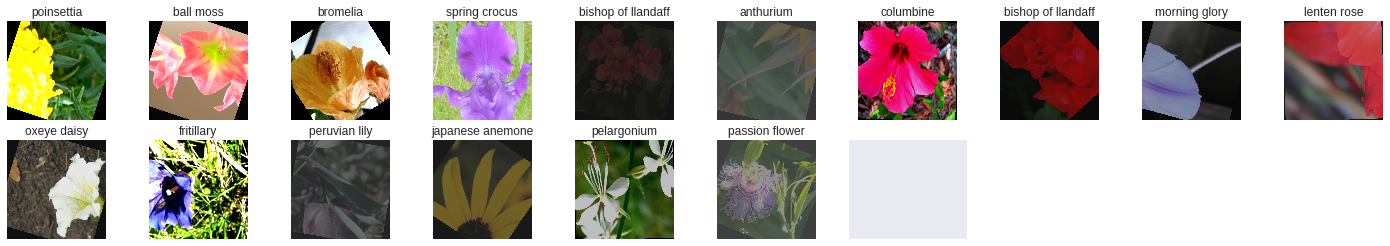

In [0]:
# Obtain one batch of training images.
dataiter = iter(dataloaders_dict['train'])
images, labels = dataiter.next()

# Plot the images in the batch, along with their corresponding labels

# Set plot dimensions
fig = plt.figure(figsize=(25,4))

# Plot each image in the batch, up tp 20
for idx in np.arange(20): # Iterative every image in the batch 
    ax = fig.add_subplot(2, 20//2, idx+1, xticks = [], yticks = []) 
    imshow(images[idx])
    ax.set_title(cat_to_name[str(labels[idx].item())])

# Building and training the classifier

## Building the classifier

### Load the pre-trained network

In [0]:
# Inception v3 from pytorch torchvision.models to get the image features.
# Throughtout the code it is named vgg16, but it's inception v3.
vgg16 = models.inception_v3(pretrained=True)

### Rewrite the last layers of the network to create a *features extractor*

In [0]:
# Accessing the last layer of Inception v3
print("Number of input features in the model:", vgg16.fc.in_features)
print("Number of output features in the model:", vgg16.fc.out_features)

# Keep "unfrozen" the last few layer. Everything after the Aux layer.
# Freezing the first 14 children modules. 
# Children 15-18 are 'Mixed7a,b,c' and Fully-Connected layers.
if feature_extract:
    ct = 0
    for name, child in vgg16.named_children():
        ct += 1
        if ct < 15:
            for name2, params in child.named_parameters():
                params.requires_grad = False
    print("\nLast few layers left unfrozen...")
    

    
# Replace the last layer and Aux layer to adjust output parameters.
# Handle the auxilary net
num_ftrs = vgg16.AuxLogits.fc.in_features
vgg16.AuxLogits.fc = nn.Linear(num_ftrs, len(cat_to_name))

# Handle the primary net
num_ftrs = vgg16.fc.in_features
vgg16.fc = nn.Linear(num_ftrs,len(cat_to_name))

# check to see that your layers produce the expected number of outputs
print("\nAux Layer of network (note number of outputs):")
print(vgg16.AuxLogits.fc)
print("\nFully-Connected Layer of network (note number of outputs):")
print(vgg16.fc)

Number of input features in the model: 2048
Number of output features in the model: 1000

Last few layers left unfrozen...

Aux Layer of network (note number of outputs):
Linear(in_features=768, out_features=102, bias=True)

Fully-Connected Layer of network (note number of outputs):
Linear(in_features=2048, out_features=102, bias=True)


### Specify Loss Function and Optimizer
Loss Function: *Cross-Entropy Loss*  
Optimizer: *Stochastic Gradient Descent*  
- momentum: 0.9
- weight decay: 1e-06 
- inital learning-rate: 1e-2  

Learning Rate Scheduler: *Cosine Annealing*


In [0]:
# if GPU is available, move the model to GPU
vgg16.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

## Optimizer

# Assign the parameters to be learned
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = vgg16.parameters()
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



# Set the learning rate for initial training
learning_rate = 1e-2

# Observe that all parameters are being optimized
# The optimizer accepts as input on the trainable parameters.
optimizer = optim.SGD(params_to_update,
                      lr=learning_rate,
                      weight_decay=1e-6,
                      momentum=0.9)

# Learning Rate Scheduler
T_max=20 # Number of Iterations for a cycle
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

# number of epochs to train the model
n_epochs = 100

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 Mixed_7a.branch3x3_1.conv.weight
	 Mixed_7a.branch3x3_1.bn.weight
	 Mixed_7a.branch3x3_1.bn.bias
	 Mixed_7a.branch3x3_2.conv.weight
	 Mixed_7a.branch3x3_2.bn.weight
	 Mixed_7a.branch3x3_2.bn.bias
	 Mixed_7a.branch7x7x3_1.conv.weight
	 Mixed_7a.branch7x7x3_1.bn.weight
	 Mixed_7a.branch7x7x3_1.bn.bias
	 Mixed_7a.branch7x7x3_2.conv.weight
	 Mixed_7a.branch7x7x3_2.bn.weight
	 Mixed_7a.branch7x7x3_2.bn.bias
	 Mixed_7a.branch7x7x3_3.conv.weight
	 Mixed_7a.branch7x7x3_3.bn.weight
	 Mixed_7a.branch7x7x3_3.bn.bias
	 Mixed_7a.branch7x7x3_4.conv.weight
	 Mixed_7a.branch7x7x3_4.bn.weight
	 Mixed_7a.branch7x7x3_4.bn.bias
	 Mixed_7b.branch1x1.conv.weight
	 Mixed_7b.branch1x1.bn.weight
	 Mixed_7b.branch1x1.bn.bias
	 Mixed_7b.branch3x3_1.conv.weight
	 Mixed_7b.branch3x3_1.bn.weight
	 Mixed_7b.branch3x3_1.bn.bias
	 Mixed_7b.branch3x3_2a.conv.weight
	 Mixed_7b.branch3x3_2a.bn.weight
	 Mixed_7b.branch3x3_2a.bn.bias
	 Mixed_7b.branch3x3_2b.conv.

### Function to save and load checkpoints

In [0]:
# The parameters for PyTorch network are stored in a model's `state_dict`.
# Contains the weight and biases matrices for each layer.
# Loading the state dict works only if the model architecture is exactly the same.
# Information about the model architecture needs to be saved in the checkpoint, along with the state dict.
# Build a dictionary with all the information you need to compeletely rebuild the model.
def save_checkpoint(model,optimizer,valid_loss,epoch):
    checkpoint = {'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': valid_loss}
    torch.save(checkpoint, 'checkpoint.tar')

# Used after initializing the model and the optimizer
def load_checkpoint(model, optimizer):
    checkpoint = torch.load('checkpoint.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss

## Training the classifier

### Training function

In [0]:
## TRAINING Inception v3
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                is_inception=True):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 2018-12-29 Added a Consine Annealing LR scheduler
        #scheduler.step()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in 'train'
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an
                    # Auxiliary output. In train mode we calculate the loss by
                    # summing the final output and the auxiliary output but in
                    # testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1) # ???
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Accuracy increased to {:.4f}. Saving model ...'.format(best_acc))
                save_checkpoint(model,optimizer,running_loss,epoch)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Option 1: Initial training

In [0]:
# track change in validation loss
valid_loss_min = np.Inf 

# Starting Epoch
e=1

# TRAIN
vgg16, val_acc_history = train_model(vgg16, 
                                     dataloaders_dict, 
                                     criterion, 
                                     optimizer,
                                     num_epochs=num_epochs)

### Option 2: Load the Model with the Lowest Validation Loss for Re-Training

In [0]:
# Load the model state_dict, optimizer state_dict, epoch, and minimal validation loss
vgg16, optimizer, e, valid_loss_min = load_checkpoint(vgg16, optimizer)

# TRAIN (cont.)
vgg16, val_acc_history = train_model(vgg16, 
                                     dataloaders_dict, 
                                     criterion, 
                                     optimizer,
                                     num_epochs=num_epochs)

## Post-training

In [0]:
# Load the model state_dict, optimizer state_dict, epoch, and minimal validation loss
vgg16, optimizer, e, valid_loss_min = load_checkpoint(vgg16, optimizer)

### Save and Load model 

In [0]:
torch.save(vgg16, '2018-12-29-model-incept-v3-AL.pt')
# vgg16 = torch.load('2018-12-29-model-incept-v3-AL.pt')

### Save mapping of classes to indices to model

In [0]:
# Mapping of Class names to Model IDs
vgg16.class_to_idx = dataloaders_dict['train'].dataset.class_to_idx

# Mapping of Class names to Flower Names
vgg16.class_to_names = cat_to_name

# Mapping of Model IDs to Flower Names
vgg16.idx_to_names = {vgg16.class_to_idx[c]: vgg16.class_to_names[c] for c in cat_to_name}

# Test Mappings
print(vgg16.class_to_idx["80"])
print(vgg16.class_to_names["80"])

## Testing the classifier

In [0]:
def test_model(model, dataloaders_dict, criterion, dataset = 'valid'):
    # Over 102 flower classes, set to track the test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(cat_to_name)))
    class_total = list(0. for i in range(len(cat_to_name)))   
    
    # Model Evaluation mode
    model.eval()
    
    # Iterate over test data
    for batch_i, (data, target) in enumerate(dataloaders_dict[dataset]):
        
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)

        # update loss 
        test_loss += loss.item()*data.size(0)

        # convert output probabilities to predicted class
        # maximal output value per input is the predicted class
        _, pred = torch.max(output, 1)    

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred)).to("cpu")
        correct = np.squeeze(correct_tensor.numpy())

        # calculate accuracy for each object class
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # Average test loss
    print('Test Loss: {:.6f}\n'.format(test_loss/len(dataloaders_dict[dataset].dataset)))
    
    # Show test accuracy
    print('Test Accuracy (Overall):\t\t%.3f%% (%2d/%2d)\n' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

    for i in range(len(cat_to_name)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

### Testing function

### Testing: Validation set

In [0]:
test_model(vgg16, dataloaders_dict, criterion)

Test Loss: 0.108209

Test Accuracy (Overall):		98.289% (804/818)

Test Accuracy of fire lily: 100% ( 8/ 8)
Test Accuracy of canterbury bells: 100% ( 4/ 4)
Test Accuracy of bolero deep blue: 100% ( 6/ 6)
Test Accuracy of pink primrose: 100% ( 5/ 5)
Test Accuracy of mexican aster: 100% ( 6/ 6)
Test Accuracy of prince of wales feathers: 100% (10/10)
Test Accuracy of moon orchid: 100% ( 5/ 5)
Test Accuracy of globe-flower: 100% ( 5/ 5)
Test Accuracy of grape hyacinth: 100% ( 1/ 1)
Test Accuracy of corn poppy: 100% ( 7/ 7)
Test Accuracy of toad lily: 100% ( 2/ 2)
Test Accuracy of siam tulip: 100% (16/16)
Test Accuracy of red ginger: 100% (11/11)
Test Accuracy of spring crocus: 100% ( 4/ 4)
Test Accuracy of alpine sea holly: 100% ( 6/ 6)
Test Accuracy of garden phlox: 100% ( 7/ 7)
Test Accuracy of globe thistle: 100% ( 4/ 4)
Test Accuracy of tiger lily: 100% ( 8/ 8)
Test Accuracy of ball moss: 100% (12/12)
Test Accuracy of love in the mist: 100% ( 5/ 5)
Test Accuracy of monkshood: 100% ( 2/ 

### Testing: Testing set

In [0]:
test_model(vgg16, dataloaders_dict, criterion, dataset = 'test')

Test Loss: 0.073089

Test Accuracy (Overall):		98.168% (804/819)

Test Accuracy of fire lily: 100% ( 5/ 5)
Test Accuracy of canterbury bells: 100% ( 3/ 3)
Test Accuracy of bolero deep blue: 100% ( 8/ 8)
Test Accuracy of pink primrose: 100% ( 4/ 4)
Test Accuracy of mexican aster: 100% ( 6/ 6)
Test Accuracy of prince of wales feathers: 100% ( 9/ 9)
Test Accuracy of moon orchid: 100% ( 9/ 9)
Test Accuracy of globe-flower: 100% ( 6/ 6)
Test Accuracy of grape hyacinth: 100% ( 3/ 3)
Test Accuracy of corn poppy: 100% ( 4/ 4)
Test Accuracy of toad lily: 66% ( 2/ 3)
Test Accuracy of siam tulip: 100% ( 9/ 9)
Test Accuracy of red ginger: 100% ( 6/ 6)
Test Accuracy of spring crocus: 100% ( 7/ 7)
Test Accuracy of alpine sea holly: 100% ( 5/ 5)
Test Accuracy of garden phlox: 100% ( 3/ 3)
Test Accuracy of globe thistle: 100% ( 2/ 2)
Test Accuracy of tiger lily: 100% ( 4/ 4)
Test Accuracy of ball moss: 100% ( 7/ 7)
Test Accuracy of love in the mist: 100% ( 2/ 2)
Test Accuracy of monkshood: 100% ( 5/ 5

### Testing: Google set

In [0]:
test_model(vgg16, dataloaders_dict, criterion, dataset = 'google')

Test Loss: 2.717128

Test Accuracy (Overall):		63.664% (636/999)

Test Accuracy of fire lily: 70% ( 7/10)
Test Accuracy of canterbury bells: 70% ( 7/10)
Test Accuracy of bolero deep blue: 70% ( 7/10)
Test Accuracy of pink primrose: 70% ( 7/10)
Test Accuracy of mexican aster: 90% ( 9/10)
Test Accuracy of prince of wales feathers: 40% ( 4/10)
Test Accuracy of moon orchid: 77% ( 7/ 9)
Test Accuracy of globe-flower: 100% (10/10)
Test Accuracy of grape hyacinth: 100% (10/10)
Test Accuracy of corn poppy: 50% ( 5/10)
Test Accuracy of toad lily: 50% ( 5/10)
Test Accuracy of siam tulip: 90% ( 9/10)
Test Accuracy of red ginger: 90% ( 9/10)
Test Accuracy of spring crocus: 40% ( 4/10)
Test Accuracy of alpine sea holly: 70% ( 7/10)
Test Accuracy of garden phlox: 90% ( 9/10)
Test Accuracy of globe thistle: 50% ( 5/10)
Test Accuracy of tiger lily: 80% ( 8/10)
Test Accuracy of ball moss: 80% ( 8/10)
Test Accuracy of love in the mist: 90% ( 9/10)
Test Accuracy of monkshood: 77% ( 7/ 9)
Test Accuracy of

### Visualize Sample Test Results

IndexError: ignored

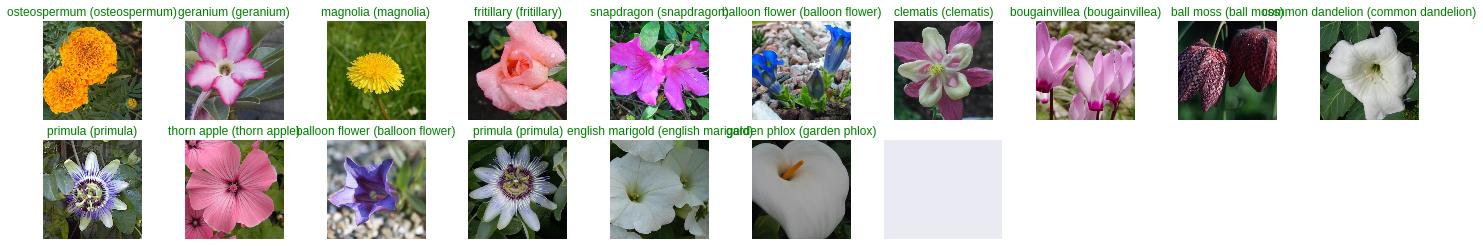

In [0]:
# obtain one batch of test images
dataiter = iter(dataloaders_dict['valid'])
images, labels = dataiter.next()
images.numpy()

# Move model inputs to cuda, if GPU available
images = images.to(device)

# Get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# Convert images to numpy for image visualization
images = images.cpu()

# plot the images in the batch, along with predicted and true labels
# GREEN if prediction is correct and RED if prediction is incorrect.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    #print(len(images))
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    #print(imshow(images[idx]))
    imshow(images[idx])
    # plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Inference for classification

## Image Preprocessing function

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Create a thumbnail image with the shorter dimension as 'input_sizse' pixels
    image.thumbnail((np.Inf,input_size)) if image.size[0] > image.size[1] else image.thumbnail((input_size,np.Inf))

    # Crop the center 'input_size' pixels
    height = image.size[1] // 2
    width = image.size[0] // 2
    new_dim = input_size // 2

    left = width - new_dim
    upper = height - new_dim
    right = width + (input_size - new_dim) # diff deals with odd input_size
    lower = height + (input_size - new_dim) # diff deals with odd input_size

    box = (left, upper, right, lower)
    image = image.crop(box)

    # Conver PIL to NumPy array
    np_image = np.array(image)

    # Scale Color channel to 0-1 range
    np_image = np_image / 255

    # Normalize to ImageNet Mean and SD
    mean = np.array([0.485, 0.456, 0.406])
    sd = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / sd

    # Rearrange image so color channels are the first dimension
    np_image = np_image.transpose(2,0,1)
    
    return np_image

## Class Prediction function (top-k)

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Load the image as a PIL object
    image = Image.open(image_path)

    # Pre-Process the input image
    np_image = process_image(image)

    # Convert to Tensor
    tensor_image = torch.Tensor(np_image)

    # Converts a PyTorch tensor and displays it
    imshow(tensor_image)

    # Moves tensor to GPU if available and prepare as input to model
    tensor_image = tensor_image.unsqueeze(dim=0).to(device)

    # Moves model to GPU if available and enters Evaluation mode
    model.eval().to(device)

    output = model(tensor_image)

    # Get the probabilities using a Softmax function
    probs = F.softmax(output, dim=1)

    # Get the topk probabilities and their indices and return them
    probs, classes = probs.topk(topk) 
    probs = probs.detach().cpu().numpy()
    classes = classes.cpu().numpy()
    return probs, classes 

## Predict a single downloaded image

In [0]:
# Downloaded image to load
image_path = "513px-Curcuma_alismatifolia_B[1].jpg"

# Predict the classes and probabilities for the image
probs, class_idx = predict(image_path,vgg16)

# Display the classes and probabilities
print("Class\t\t\tProbability")
print("-----\t\t\t-----------")
print('\n'.join('{}\t\t{:f}'.format(vgg16.idx_to_names[k[0]],probs[0][k[0]]) for k in enumerate(class_idx[0])))

Class			Probability
-----			-----------
pink primrose		0.999906
globe thistle		0.000084
blanket flower		0.000010
trumpet creeper		0.000000
blackberry lily		0.000000
